<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/module2-Train/LS_DS17_422_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Unit 4, Sprint 2, Module 2*

---

# Train (Prepare)
__*Neural Network Foundations*__

## Learning Objectives
* <a href="#p1">Part 1</a>: explain the intuition behind backpropagation and gradient descent
* <a href="#p2">Part 2</a>: able to discuss the importance of batch size
* <a href="#p3">Part 3</a>: able to discuss the importance of learning rate

## Summary of Yesterday

Yesterday, we learned about some of the principal components of Neural Networks: Neurons, Weights, Activation Functions, and layers (input, output, & hidden). Today, we will reinforce our understanding of those components and introduce the mechanics of training a neural network. Feed-forward neural networks, such as multi-layer perceptrons (MLPs), are almost always trained using some variation of gradient descent where the gradient has been calculated by backpropagation.

  <center><img src="https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/main/module1-Architect/IMG_0167.jpeg" width=400></center>

- There are three kinds of layers: input, hidden, and output layers.
- Each layer is made up of **n** individual neurons (aka activation units) which have a corresponding weight and bias.
- Signal is passed from layer to layer through a network by:
 - Taking in inputs from the training data (or previous layer)
 - Multiplying each input by its corresponding weight (think arrow/connecting line)
 - Adding a bias to this weighted some of inputs and weights
 - Activating this weighted sum + bias by squishifying it with sigmoid or some other activation function. With a single perceptron with three inputs, calculating the output from the node is done like so:
\begin{align}
 y = sigmoid(\sum(weight_{1}input_{1} + weight_{2}input_{2} + weight_{3}input_{3}) + bias)
\end{align}
 - this final activated value is the signal that gets passed onto the next layer of the network.
 

## Training a Neural Network: *Formal Summary*

0. Pick a network architecture
   - No. of input units = No. of features
   - No. of output units = Number of Classes (or expected targets)
   - Select the number of hidden layers and number of neurons within each hidden layer
1. Randomly initialize weights, $\theta$
2. Implement forward propagation to get $h_{\theta}(x^{(i)})$ for any $x^{(i)}$
3. Implement code to compute a cost function $J(\theta)$
4. Implement backpropagation to compute partial derivatives $\frac{\delta}{\delta\theta_{jk}^{l}}{J(\theta)}$
5. Use gradient descent (or other advanced optimizer) with backpropagation to minimize $J(\theta)$ as a function of parameters $\theta$
6. Repeat steps 2 - 5 until cost function is 'minimized' or some other stopping criteria is met. One pass over steps 2 - 5 is called an iteration or epoch.

# Backpropagation & Gradient Descent (Learn)
<a id="p1"></a>

## Overview

Backpropagation is short for ["Backwards Propagation of errors"](https://en.wikipedia.org/wiki/Backpropagation) and refers to a specific (rather calculus intensive) algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch. Our purpose today is to demonstrate the backpropagation algorithm on a simple Feedforward Neural Network and in doing so help you get a grasp on the main process. If you want to understand all of the underlying calculus of how the gradients are calculated then you'll need to dive into it yourself, [3Blue1Brown's video is a great starting place](https://www.youtube.com/watch?v=tIeHLnjs5U8). I also highly recommend this Welch Labs series [Neural Networks Demystified](https://www.youtube.com/watch?v=bxe2T-V8XRs) if you want a rapid yet orderly walk through of the main intuitions and math behind the backpropagation algorithm. 

### What is a Gradient?

> In vector calculus, the gradient is a multi-variable generalization of the derivative. 

The gradients that we will deal with today will be vector representations of the derivative of the activation function. 

## Follow Along

In this section, we will begin a simple neural network using base TensorFlow. We'll focus on using a __Feed Forward Neural Network__ to predict test scores. 

<center><img src="https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/main/module1-Architect/IMG_99C94113202D-1.jpeg"width=500></center>

### Generate some Fake Data

In [1]:
import tensorflow as tf

# Imagine that our data is drawn from a linear function
# y = 3.5*hours_studying + 50

TRUE_W = 3.5
TRUE_b = 50.0
NUM_EXAMPLES = 1000

# Default is mean=0 std=1, dtype=tf.float32, a subclass of numpy array!
inputs = tf.random.normal(shape=[NUM_EXAMPLES], mean=0, stddev=0, dtype=tf.float32, seed=42)
noise = tf.random.normal(shape=[NUM_EXAMPLES], mean=0, stddev=0, dtype=tf.float32, seed=42)

outputs = inputs * TRUE_W + TRUE_b + noise

In [2]:
type(inputs)

tensorflow.python.framework.ops.EagerTensor

In [3]:
inputs[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.1565905 ,  0.9360708 , -0.3900228 , -1.4862837 , -0.26932803],
      dtype=float32)>

In [4]:
noise[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.8507488 ,  1.4934216 ,  0.18194261, -0.6067917 ,  0.5364568 ],
      dtype=float32)>

In [5]:
outputs[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47.802685, 54.76967 , 48.81686 , 44.191216, 49.593807],
      dtype=float32)>

### Loss Function
Here we will use Mean Squared Error (MSE), because this is a regression problem. We are trying to predict a continuous target.

In [6]:
def loss(target_y, predicted_y):
  "MSE, Note that the loss function operates over the entire array"
  # Computes the mean of elements across dimensions of a tensor.
  # Computes square of x element-wise.
  return tf.reduce_mean(tf.square(target_y - predicted_y))

### Neural Network Architecture
Lets create a Neural Network class called "Model" to contain this functionality. Note: This is essentially a linear regression whose coefficients are trained by gradient descent. In practice, gradient descent works on much more complex function like the multi-layer networks we constructed yesterday.

In [102]:
dir(tf)[:20] + dir(tf)[-20:]

['AggregationMethod',
 'Assert',
 'CriticalSection',
 'DType',
 'DeviceSpec',
 'GradientTape',
 'Graph',
 'IndexedSlices',
 'IndexedSlicesSpec',
 'Module',
 'Operation',
 'OptionalSpec',
 'RaggedTensor',
 'RaggedTensorSpec',
 'RegisterGradient',
 'SparseTensor',
 'SparseTensorSpec',
 'Tensor',
 'TensorArray',
 'TensorArraySpec',
 'type_spec_from_value',
 'types',
 'uint16',
 'uint32',
 'uint64',
 'uint8',
 'unique',
 'unique_with_counts',
 'unravel_index',
 'unstack',
 'variable_creator_scope',
 'variant',
 'vectorized_map',
 'version',
 'where',
 'while_loop',
 'xla',
 'zeros',
 'zeros_initializer',
 'zeros_like']

*In TensorFlow the differences between constants and variables are that when you declare some constant, its value can't be changed in the future (also the initialization should be with a value, not with operation). Nevertheless, when you declare a Variable, you can change its value in the future with tf.assign() method (and the initialization can be achieved with a value or operation).*

In [9]:
# Experiment with tensor operator
w = tf.Variable([[1.], [2.]])
x = tf.constant([[3., 4.]])
print(w)
x

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.],
       [2.]], dtype=float32)>


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[3., 4.]], dtype=float32)>

In [10]:
# Like numpy expands dimensions:
"""
[1,1]   [3,4]   [4,5]
[2,2] + [3,4] = [5,6]
"""
w+x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4., 5.],
       [5., 6.]], dtype=float32)>

In [11]:
# It's an element-wise multiplication
tf.matmul(w, x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3., 4.],
       [6., 8.]], dtype=float32)>

In [17]:
# inherits from the object class
class Model(object):

  def __init__(self):
    self.W = tf.Variable(8.0)
    self.b = tf.Variable(40.0)

  # So, the __init__ method is used when the class is called to initialize the instance, 
  # while the __call__ method allows the class's instance to be called as a function, and returns a value
  def __call__(self, x):
    return self.W * x + self.b

model = Model()

In [34]:
print(type(model))
# W and b are of type tensor
print(type(model(3.0)))
print(model(3.0))
print(model(3.0).numpy())

<class '__main__.Model'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(64.0, shape=(), dtype=float32)
64.0


In [27]:
# Model() passes self to __call__() method
Model().__call__(3) == 64

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [32]:
# Alternative way to call the __call__() method on the instance of class Model: Model()
Model()(3)

<tf.Tensor: shape=(), dtype=float32, numpy=64.0>

**Tensor has a shape, dtype and numpy value**

### Initial Weights
The initial weights in our model were arbitrary. In practice, weights are initialized randomly. 

In [31]:
loss(outputs, model(inputs))

<tf.Tensor: shape=(), dtype=float32, numpy=120.73599>

> *In **'%x.yf'** x is the <u>minimum</u> field width, and y is number of digits after the decimal point.*

For example, to force the output to have at least 6 characters with 2 after the decimal point you do:
```
'%06.2f' % (3.141592653589793,)
Output: 003.14```

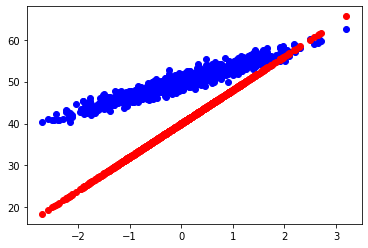

Current loss: 120.735992


In [35]:
import matplotlib.pyplot as plt

# blue is the provided target value
plt.scatter(inputs, outputs, c='b')

# red is the prediction.
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(outputs, model(inputs)).numpy())

In [37]:
print('Current loss: %1.2f' % loss(outputs, model(inputs)).numpy())

Current loss: 120.74


### Update Weights Based on Gradient

> *Assigning blame for bad predictions and delivering justice - repeatedly and a little bit at a time*

You should also know that with neural networks it is common to have gradients that are not convex (like what we saw when we applied gradient descent to linear regression). 

Due to the high complexity of these models and their nonlinearity, it is common for gradient descent to get stuck in a local minimum, but there are ways to combat this:

1) Stochastic Gradient Descent

2) More advanced Gradient-Descent-based "Optimizers" - See Stretch Goals.

GradientTape():
Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched". Trainable variables (created by tf.Variable or tf.compat.v1.get_variable, where trainable=True is default in both cases) are automatically watched. Tensors can be manually watched by invoking the watch method on this context manager.

In [39]:
 def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t: 
        # recording :
        current_loss = loss(outputs, model(inputs))

    #takes the gradient of current_loss vs W and b, dw is actually d(Loss)/dW
    dW, db = t.gradient(current_loss, [model.W, model.b])
    # for dW>0 lowering W with lower Loss (Learning_rate>0): W = W - learning_rate * dW
    # assign_sub(ref, value) >> ref = ref-value (assign subtraction)
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

    return current_loss

In [101]:
class B(object):
    def __init__(self):
        self.b1 = 20

def test1(a, b, model1):
    a = a + 2
    b.b1 = b.b1 + 2
    model1.W = tf.constant(-5.5)
#     model1.W = model1.W.assign_sub(5.5)
    return b

model = Model()
b = B()
a = 1

# model.W = tf.Variable(12.3)
b = test1(a, b, model)
a, b.b1, model.W


(1, 22, <tf.Tensor: shape=(), dtype=float32, numpy=-5.5>)

### Train the Network

In [40]:
model = Model()

# Store Some history of weights
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    # W.numpy() gets the value of the tensor W
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    # current_loss is the same as train return value
    current_loss = loss(outputs, model(inputs))

    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f loss=%2.5f' % (epoch, Ws[-1], bs[-1], current_loss))

Epoch  0: W=8.00 b=40.00 loss=120.73599
Epoch  1: W=7.14 b=42.01 loss=77.77589
Epoch  2: W=6.44 b=43.61 loss=50.23418
Epoch  3: W=5.88 b=44.89 loss=32.57647
Epoch  4: W=5.43 b=45.92 loss=21.25525
Epoch  5: W=5.06 b=46.74 loss=13.99636
Epoch  6: W=4.77 b=47.40 loss=9.34195
Epoch  7: W=4.53 b=47.92 loss=6.35739
Epoch  8: W=4.34 b=48.34 loss=4.44353
Epoch  9: W=4.18 b=48.68 loss=3.21622


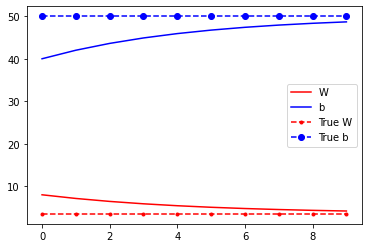

In [61]:
import matplotlib.pyplot as plt
# Format Strings: fmt = '[marker][line][color]'
#  plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
plt.plot(epochs, Ws, 'r', epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), '.--r',
         [TRUE_b] * len(epochs), 'o--b')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()

# Batch Size (Learn)

## Overview

The What - Stochastic Gradient Descent calculates an approximation of the gradient over the entire dataset by reviewing the predictions of a random sample. 

The Why - *Speed*. Calculating the gradient over the entire dataset is extremely expensive computationally. 

### Batch Size
**Batches are the number of observations our model is shown to make predictions and update the weights. Batches are selected randomly during epoch. All observations are considered when passing thru an epoch at some point.**

* Smaller Batch = Slower Run Time (but maybe more accurate results)
* Default Batch = Balance between speed and accuracy
* Large Batch = Very fast, but not nearly as accurate.

### Baseline Model

In [197]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

Accent


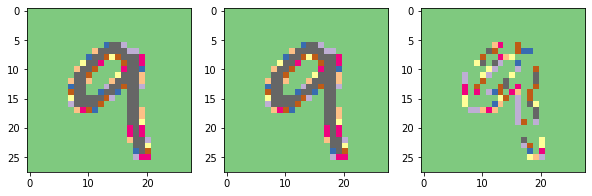

binary


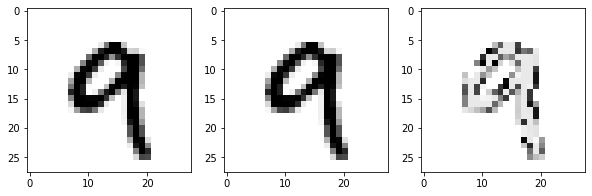

In [195]:
import matplotlib.pyplot as plt
cmaps = ['Accent', 'binary']
for i, cmap in enumerate(cmaps):
    fig= plt.figure(figsize=(10,20))
    print(cmap)
    plt.subplot(2,3,1+i*3)
    plt.imshow(X_train[110], cmap)
    ax2 = plt.subplot(2,3,2+i*3)
    plt.imshow(X_train[110]/800, cmap)
    plt.subplot(2,3,3+3*i).imshow(X_train[110]*800, cmap)
    plt.show()

> Seems like scaling down the number in the array does not change the color mapping. However, scaling up changes the color assignment.

In [198]:
# Normalize the colors between 0 and 1, colors won't change
X_train = X_train / 255.
X_test = X_test / 255.

# it's 28pixels * 28 pixels
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [300]:
# Our Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers

def create_model(lr=.01):
    """
    Stochastic Gradient Descent SGD optimizer
    784+1 * 32+1 * 32+1 * 10
    """
    opt = SGD(learning_rate=lr)

    model = Sequential(
        [
        # 784 inputs + 1 bias connect to 32 1st layer Hiddent neurons
        Dense(32, activation='relu', input_dim=784, 
            kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42),
            bias_initializer=initializers.Ones()
             ),
        # 32 1st-H-Neurons + 1 bias connected to 32 2'nd layer H-Neurons
        Dense(32, activation='relu', 
            kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=42), 
            bias_initializer=initializers.Zeros()
             ),
        # 32 2nd-H-neurons connect to 10 Output neurons
        Dense(10, activation='softmax', 
            kernel_initializer=initializers.Ones(), 
            bias_initializer=initializers.Zeros()
             )       
        ]
    )
    # sparse_categorical_crossentropy is good for multilable classification, when target labels are integer
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [253]:
mnist_model = create_model()
[m for m in dir(mnist_model) if not m.startswith("_")]

['activity_regularizer',
 'add',
 'add_loss',
 'add_metric',
 'add_update',
 'add_variable',
 'add_weight',
 'apply',
 'build',
 'built',
 'call',
 'compile',
 'compiled_loss',
 'compiled_metrics',
 'compute_dtype',
 'compute_mask',
 'compute_output_shape',
 'compute_output_signature',
 'count_params',
 'distribute_strategy',
 'dtype',
 'dtype_policy',
 'dynamic',
 'evaluate',
 'evaluate_generator',
 'fit',
 'fit_generator',
 'from_config',
 'get_config',
 'get_input_at',
 'get_input_mask_at',
 'get_input_shape_at',
 'get_layer',
 'get_losses_for',
 'get_output_at',
 'get_output_mask_at',
 'get_output_shape_at',
 'get_updates_for',
 'get_weights',
 'history',
 'inbound_nodes',
 'input',
 'input_mask',
 'input_names',
 'input_shape',
 'input_spec',
 'inputs',
 'layers',
 'load_weights',
 'loss',
 'losses',
 'make_predict_function',
 'make_test_function',
 'make_train_function',
 'metrics',
 'metrics_names',
 'name',
 'name_scope',
 'non_trainable_variables',
 'non_trainable_weights',
 '

In [254]:
mnist_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [255]:
a = (785*32, 33*32, 33*10)
a, sum(list(a))

((25120, 1056, 330), 26506)

### Fit the model for a parameter
This is a function to fit the model for a parameter with a list of values

In [387]:
def fit_param(param_lst, key):
    """
    This function fits a ANN created by create_model() while sweeping a parameter
    param_list: list of values for the parameter
    key: a string representing the parameter. Choices are "lr", "batch_size", "epochs"
    return: a dictionary with 
    {f"{par}_": [fitted model, fitted result],
    "key": key, "param_lst": param_lst}
    """
    lr_par = 0.01 
    batch_par = 32
    epoch_par = 25
    param_dict = {"lr": lr_par, "batch_size": batch_par, "epochs": epoch_par}
    model_dict={}
    model_dict["key"] = key
    model_dict["param_lst"] = param_lst
    for par in param_lst:
        param_dict[key] = par
        print(f"********* Fitting for {key}={param_dict[key]} *********")
        model_dict.setdefault(f"{par}_", [None, None])
        model_dict[f"{par}_"][0] = create_model(param_dict["lr"])
        model_dict[f"{par}_"][1] = model_dict[f"{par}_"][0].fit(X_train, y_train,
                                                                             # Hyperparameters!
                                                                             epochs=param_dict["epochs"],
                                                                             batch_size=param_dict["batch_size"],
                                                                             validation_data=(X_test, y_test))
    return model_dict

### Visualize the metrics
This is a function to plot the metrics for different values of a paramter

In [388]:
import seaborn as sns
import pandas as pd

def viz_param(model_dict):
    """
    Returns a concatinated dataframe of the fitted results and 
    plots the validation accuracy and loss for different values of the parameter
    """
    results = []
    for par in model_dict["param_lst"]:
        results.append(model_dict[f"{par}_"][1])

    df_lst = []
    param_name = f"{model_dict['key']}_"
    
    for res, par in zip(results, model_dict["param_lst"]):
        df = pd.DataFrame.from_dict(res.history)
        df['epoch'] = df.index.values
        df[param_name] = f"{par}_"
        df_lst.append(df)

    df = pd.concat(df_lst, axis=0)
    df[param_name] = df[param_name].astype('str')
    
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    sns.lineplot(x='epoch', y='val_accuracy', hue=param_name, data=df, ax=ax1)
    ax2 = plt.subplot(1,2,2)
    sns.lineplot(x='epoch', y='val_loss', hue=param_name, data=df, ax=ax2);
    return df

### Batch Size
Let's run a series of experiments for a default, small, and large batch size.

Default batch size is 32.

> *Seems like the entire X is divided into batches of size n and the NN is trained on each batch of n samples and W, b get's updated at the end of each batch of n. Once all batches in a training dataset are trained the epoch counter goes up and we create another set of batches randomly and exclusively (like Kfold) and retrain based on each of the new batches again. For **stochastic GD, batch size is 1** and the accuracy of each update is low but number of updates are maximum, as the # of back propagation is maximum = "one back-propagation for each batch of each epoch.". That resuls in long computing time for each epoch. The training trend is very noisy since the updates are done based on individual samples. However in each epoch we get more correction and accuracy improves more.
In **batch size GD, the batch size is equal to training set**. Hence the epoch looks at the same entire training dataset repeatedly and make an update on every epoch run. Less noisy and minimum number of back propagation = one back-propagation per epoch. Hence runtime is faster per epoch. However need a large memory to process the entire dataset in one shot.*

In [389]:
batch_lst = [8, 32, 512]
model_batch = fit_param(batch_lst, "batch_size")

********* Fitting for batch_size=8 *********
Epoch 1/25
7500/7500 [==============================] - 5s 653us/step - loss: 1.5308 - accuracy: 0.4774 - val_loss: 0.3601 - val_accuracy: 0.8937
Epoch 2/25
7500/7500 [==============================] - 4s 587us/step - loss: 0.3344 - accuracy: 0.9012 - val_loss: 0.2704 - val_accuracy: 0.9198
Epoch 3/25
7500/7500 [==============================] - 4s 599us/step - loss: 0.2464 - accuracy: 0.9278 - val_loss: 0.2046 - val_accuracy: 0.9389
Epoch 4/25
7500/7500 [==============================] - 5s 606us/step - loss: 0.1922 - accuracy: 0.9438 - val_loss: 0.1852 - val_accuracy: 0.9427
Epoch 5/25
7500/7500 [==============================] - 5s 633us/step - loss: 0.1604 - accuracy: 0.9518 - val_loss: 0.1668 - val_accuracy: 0.9471
Epoch 6/25
7500/7500 [==============================] - 5s 640us/step - loss: 0.1407 - accuracy: 0.9572 - val_loss: 0.1440 - val_accuracy: 0.9573
Epoch 7/25
7500/7500 [==============================] - 5s 675us/step - loss: 0

### Visualization of Results

In [390]:
model_batch["512_"][1].history

{'loss': [2.301809310913086,
  2.3001580238342285,
  2.2981884479522705,
  2.2956862449645996,
  2.2923336029052734,
  2.287515640258789,
  2.2800958156585693,
  2.2677462100982666,
  2.2455739974975586,
  2.20272159576416,
  2.118558168411255,
  1.9713282585144043,
  1.7688437700271606,
  1.5399081707000732,
  1.334890365600586,
  1.1719529628753662,
  1.0369874238967896,
  0.9250653386116028,
  0.836886465549469,
  0.7694619297981262,
  0.7168025970458984,
  0.6748578548431396,
  0.6411204934120178,
  0.6134116649627686,
  0.5903438329696655],
 'accuracy': [0.12219999730587006,
  0.11248333007097244,
  0.11486666649580002,
  0.13920000195503235,
  0.17563332617282867,
  0.2255166620016098,
  0.26159998774528503,
  0.2984499931335449,
  0.3239666521549225,
  0.32998332381248474,
  0.3268333375453949,
  0.35214999318122864,
  0.4106333255767822,
  0.4874666631221771,
  0.5687166452407837,
  0.6340333223342896,
  0.680983304977417,
  0.7171666622161865,
  0.7448166608810425,
  0.7660166

,loss,accuracy,val_loss,val_accuracy,epoch,batch_size_
0,0.904966,0.705683,0.360123,0.8937,0,8_
1,0.312134,0.907650,0.270353,0.9198,1,8_
2,0.233015,0.931550,0.204598,0.9389,2,8_
3,0.187764,0.944467,0.185239,0.9427,3,8_
4,0.160360,0.952217,0.166757,0.9471,4,8_


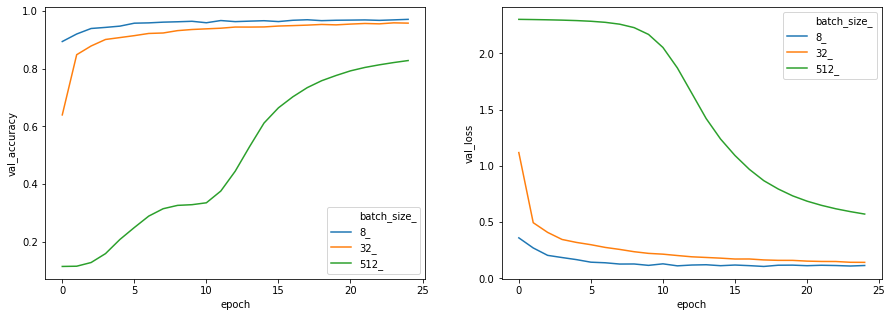

In [391]:
df_batch = viz_param(model_batch)
df_batch.head()

> **smaller batch size does more back propagation and achieve higher accuracy per epoch. But it takes longer to run each epoch**

# Learning Rate (Learn)

## Overview

Learning Rate controls the size of the update to our weights that the optimization algorithm makes. VERY IMPORTANT hyperparameter.

* Too high of a learning rate causes unstable results
* Too Low of a learning rate the model will underfit
* Goldilocks parameters - it needs to be "just right"
* Scale of 0-1

## Follow Along

Same experiment with Batch but different learning rates:
* High Learning = .75
* Default Learning = .01
* Low Learning Rate = .001

### Default Learning Rate
Batch size is kept at default 32

In [392]:
lr_lst = [0.001,0.01,0.75]
model_lr = fit_param(lr_lst, "lr")

********* Fitting for lr=0.001 *********
Epoch 1/25
1875/1875 [==============================] - 2s 817us/step - loss: 2.3020 - accuracy: 0.1262 - val_loss: 2.2999 - val_accuracy: 0.1136
Epoch 2/25
1875/1875 [==============================] - 1s 664us/step - loss: 2.2992 - accuracy: 0.1140 - val_loss: 2.2965 - val_accuracy: 0.1287
Epoch 3/25
1875/1875 [==============================] - 1s 653us/step - loss: 2.2954 - accuracy: 0.1458 - val_loss: 2.2911 - val_accuracy: 0.1945
Epoch 4/25
1875/1875 [==============================] - 1s 736us/step - loss: 2.2894 - accuracy: 0.2054 - val_loss: 2.2811 - val_accuracy: 0.2654
Epoch 5/25
1875/1875 [==============================] - 1s 707us/step - loss: 2.2774 - accuracy: 0.2749 - val_loss: 2.2591 - val_accuracy: 0.3116
Epoch 6/25
1875/1875 [==============================] - 1s 742us/step - loss: 2.2487 - accuracy: 0.3219 - val_loss: 2.1997 - val_accuracy: 0.3326
Epoch 7/25
1875/1875 [==============================] - 1s 733us/step - loss: 2.170

### Visualization of Results

,loss,accuracy,val_loss,val_accuracy,epoch,lr_
0,2.301324,0.120383,2.299946,0.1136,0,0.001_
1,2.298389,0.117367,2.296484,0.1287,1,0.001_
2,2.294137,0.161867,2.291074,0.1945,2,0.001_
3,2.286896,0.224217,2.281112,0.2654,3,0.001_
4,2.272140,0.291950,2.259059,0.3116,4,0.001_


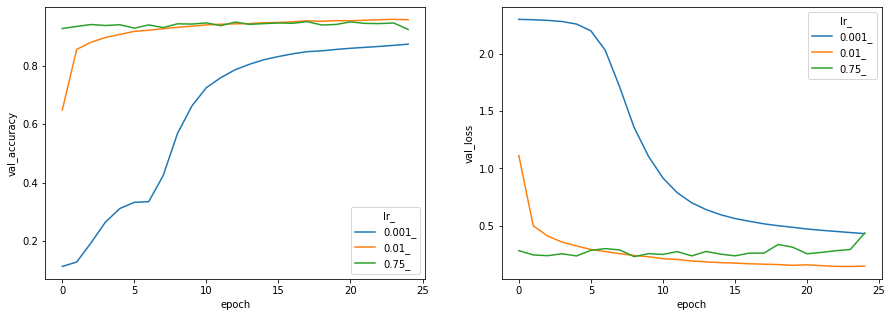

In [393]:
df_lr = viz_param(model_lr)
df_lr.head()

**Large learning rate cannot converge. Too small of a learning rate needs lots of epochs to get to high accuracy, and it's slow for the same batch_size**

### epochs
epoch is like iteration over the dataset. AT some epoch we won't get more improvement.
let's keep batch_size=32, and lr=0.01 and run for 50 epoch

In [394]:
epoch_lst = [50]
model_epoch = fit_param(epoch_lst, "epochs")

********* Fitting for epochs=50 *********
Epoch 1/50
1875/1875 [==============================] - 2s 740us/step - loss: 2.2560 - accuracy: 0.1815 - val_loss: 1.1180 - val_accuracy: 0.6415
Epoch 2/50
1875/1875 [==============================] - 1s 684us/step - loss: 0.8218 - accuracy: 0.7466 - val_loss: 0.5077 - val_accuracy: 0.8400
Epoch 3/50
1875/1875 [==============================] - 1s 651us/step - loss: 0.4687 - accuracy: 0.8633 - val_loss: 0.3997 - val_accuracy: 0.8832
Epoch 4/50
1875/1875 [==============================] - 1s 679us/step - loss: 0.3936 - accuracy: 0.8855 - val_loss: 0.3583 - val_accuracy: 0.8940
Epoch 5/50
1875/1875 [==============================] - 1s 668us/step - loss: 0.3434 - accuracy: 0.8990 - val_loss: 0.3176 - val_accuracy: 0.9094
Epoch 6/50
1875/1875 [==============================] - 1s 665us/step - loss: 0.3109 - accuracy: 0.9111 - val_loss: 0.2963 - val_accuracy: 0.9175
Epoch 7/50
1875/1875 [==============================] - 1s 675us/step - loss: 0.29

,loss,accuracy,val_loss,val_accuracy,epoch,epochs_
0,2.049995,0.295683,1.117957,0.6415,0,50_
1,0.672956,0.795150,0.507652,0.8400,1,50_
2,0.449212,0.869800,0.399669,0.8832,2,50_
3,0.381581,0.889483,0.358283,0.8940,3,50_
4,0.341898,0.901450,0.317566,0.9094,4,50_


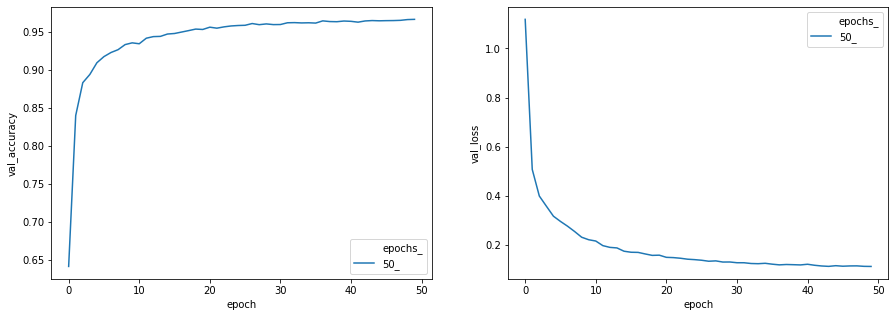

In [395]:
df_epoch = viz_param(model_epoch)
df_epoch.head()